# Proteomic data across studies
## Setup
### Import packages

In [1]:
from pathlib import Path
from warnings import warn

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rbc_gem_utils import (ANNOTATION_PATH, DATABASE_PATH, EXTERNAL_PATH,
                           INTERIM_PATH, RESULTS_PATH, ROOT_PATH,
                           check_database_version_online, check_version,
                           show_versions)
from rbc_gem_utils.database.uniprot import (UNIPROT_VERSION_EXPECTED,
                                            get_version_UniProt, query_UniProt)

# Display versions of last time notebook ran and worked
show_versions()
plt.rcParams["font.family"] = "Arial"


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

## Visualize Protein Table


In [2]:
# Turned into an xlsx where keys are sheet names and values are DataFrames representing the sheet
all_figure_data = {}
imagetype = "png"
transparent = True
save_figures = True
dpi = 300

data_path = Path("data").resolve()
models_path = Path("models").resolve()
figures_path = Path("figures").resolve()
version = "1.2.0"

#### Sorted by publication year (original)

In [3]:
df_proteins = pd.read_csv(
    f"{data_path}/proteomic_evidence_table.tsv",
    sep="\t",
    index_col=0,
)
df_proteins.columns.name = "pubmed"

# Order by number of times a single  protein was detected across studies
# protein_ids_ordered = df_proteins.sum(axis=1).sort_values(ascending=False).index.values
# df_proteins = df_proteins.loc[protein_ids_ordered, :]
# Transport for figure
df_proteins = df_proteins.T
df_proteins

Uniprot,P04406,P11142,Q00013,P00915,P27105,P00352,P16452,P52907,P55072,P69905,...,Q8NC60,Q8NC56,P28340,P28799,Q8NBT2,Q8NBM8,P29466,Q8NBI6,Q8NBF6,A0A024RBG1
pubmed,,,,,,,,,,,,,,,,,,,,,
pubmed:12362340,1,1,1,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
pubmed:14963112,1,1,1,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
pubmed:16861337,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
pubmed:18399644,1,1,0,0,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
pubmed:18494517,1,1,1,1,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
pubmed:18614565,1,1,1,1,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
pubmed:19778645,1,0,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
pubmed:22157974,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pubmed:22954596,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


#### Reordered

In [4]:
# Order by number of proteins detected in a single study
df_proteins_reordered = df_proteins.T.copy()
pubmed_ids_ordered = (
    df_proteins_reordered.sum(axis=0).sort_values(ascending=False).index.values
)
df_proteins_reordered = df_proteins_reordered.loc[:, pubmed_ids_ordered]
df_proteins_reordered = df_proteins_reordered.T
df_proteins_reordered

Uniprot,P04406,P11142,Q00013,P00915,P27105,P00352,P16452,P52907,P55072,P69905,...,Q8NC60,Q8NC56,P28340,P28799,Q8NBT2,Q8NBM8,P29466,Q8NBI6,Q8NBF6,A0A024RBG1
pubmed,,,,,,,,,,,,,,,,,,,,,
pubmed:38964323,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,1,0
pubmed:28689405,1,1,1,1,1,1,1,1,1,1,...,0,1,0,0,0,1,0,1,0,0
pubmed:30327373,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,0,0,0,0
pubmed:28263177,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0
pubmed:37942280,1,1,1,1,1,1,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
pubmed:35858567,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
pubmed:33806028,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
pubmed:18614565,1,1,1,1,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
pubmed:38147558,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1


### Visualization

In [5]:
df_figure_data = df_proteins.copy()
df_figure_data = df_proteins_reordered.copy()
min_count = 0
max_count = 20
fontsize = 12

edgecolor = "black"
edgewidth = 0.5
bar_size = 0.75
as_percentages = True
cmin, cmax = (0.05, 1)

cmap = mpl.colormaps.get_cmap("terrain_r")
no_evidence_color = mpl.colors.to_rgba_array("xkcd:white")

In [6]:
all_figure_data["ProteomicEvidenceAll"] = df_figure_data.copy()


df_value_counts = df_figure_data.sum(axis=0).value_counts().sort_index()
value_counts = df_value_counts[df_value_counts.index <= max_count].to_dict()
value_counts[max(value_counts.keys())] += df_value_counts[
    df_value_counts.index > max_count
].sum()
value_counts = {int(k): v for k, v in value_counts.items()}
df_value_counts = pd.Series(value_counts, name="Total")
id_fix_dict = {max_count: f"$\geq${str(max_count)}"}
if min_count:
    value_counts = df_value_counts[df_value_counts.index >= min_count].to_dict()
    value_counts[min(value_counts.keys())] += df_value_counts[
        df_value_counts.index < min_count
    ].sum()
    value_counts = {int(k): v for k, v in value_counts.items()}
    id_fix_dict[min_count] = f"{str(min_count)}$\geq$"

value_counts = {id_fix_dict.get(k, k): v for k, v in value_counts.items()}


df_value_counts = pd.DataFrame.from_dict(
    value_counts, orient="index", columns=["Total"]
)
df_value_counts.index.name = "Proteomic evidence (#studies)"
# Add colormap to table
cmap_dict = dict(
    zip(
        df_value_counts.index, cmap(np.linspace(cmin, cmax, len(df_value_counts.index)))
    )
)

df_value_counts_colors = df_value_counts.copy()
df_value_counts_colors["Colors"] = cmap_dict
df_value_counts_colors = df_value_counts_colors.reindex(
    index=df_value_counts_colors.index[::-1]
)
df_value_counts_colors.index = df_value_counts_colors.index.astype(str)
df_value_counts_colors

,Total,Colors
Proteomic evidence (#studies),,
$\geq$20,118,"[0.2, 0.2, 0.6, 1.0]"
19,68,"[0.13725490196078433, 0.3254901960784314, 0.72..."
18,74,"[0.06928104575163399, 0.46143790849673205, 0.8..."
17,81,"[0.0013071895424836603, 0.5973856209150327, 0...."
16,85,"[0.0, 0.7, 0.7, 1.0]"
15,86,"[0.0, 0.7941176470588236, 0.4176470588235294, ..."
14,87,"[0.19215686274509802, 0.8384313725490197, 0.43..."
13,88,"[0.39607843137254906, 0.8792156862745099, 0.47..."
12,97,"[0.6, 0.92, 0.52, 1.0]"


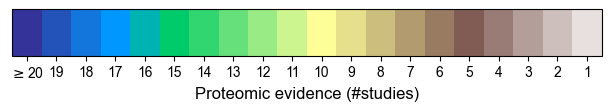

In [7]:
orientation = "horizontal"
figsize = (1 if orientation == "vertical" else 6, 6 if orientation == "vertical" else 1)
fig_colorbar, cbar_ax = plt.subplots(figsize=figsize, layout="constrained")

cmap_dict = df_value_counts_colors["Colors"].to_dict()
cmap_segmented = mpl.colors.LinearSegmentedColormap.from_list(
    "legend", list(cmap_dict.values()), len(cmap_dict)
)
xticks = list(np.linspace(0, len(cmap_dict) - 1, len(cmap_dict)) + 0.5)
if orientation == "vertical":
    cmap_segmented = cmap_segmented.reversed("legend")
    xticks.reverse()

norm = mpl.colors.BoundaryNorm(
    np.linspace(0, len(cmap_dict), len(cmap_dict) + 1), cmap_segmented.N
)
colorbar = fig_colorbar.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap_segmented),
    cax=cbar_ax,
    orientation=orientation,
    label=df_value_counts_colors.index.name,
)
colorbar.set_ticks(
    xticks, minor=False, labels=df_value_counts_colors.index, fontsize=fontsize - 2
)
colorbar.set_ticks([], minor=True)
cbar_ax.set_xlabel(df_value_counts_colors.index.name, fontdict={"size": fontsize})
fig_colorbar;

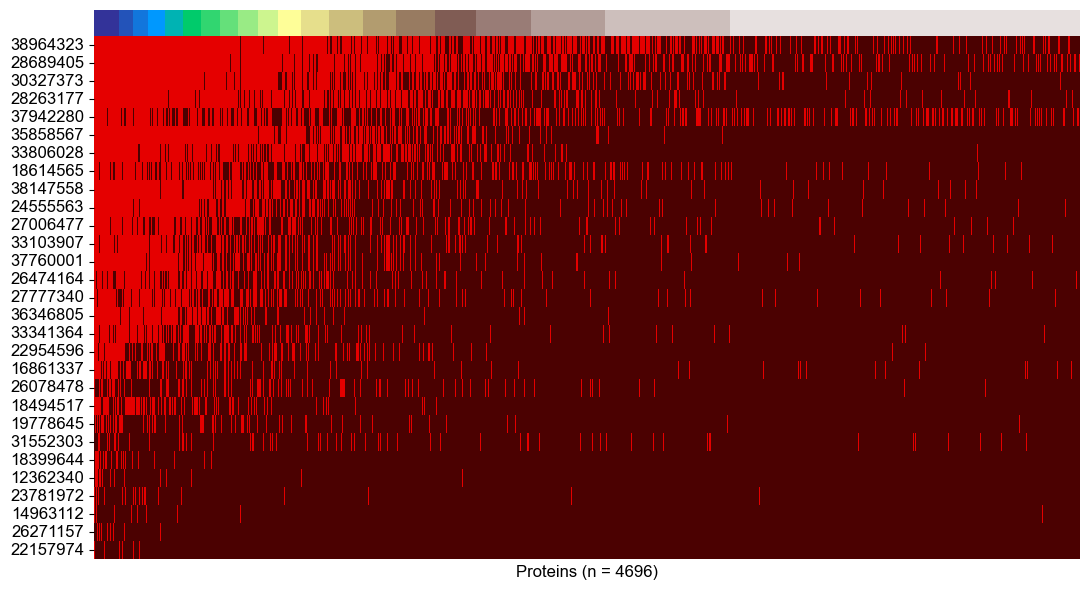

In [8]:
fig = mpl.figure.Figure(figsize=(11, 6))
gs = mpl.gridspec.GridSpec(2, 1, hspace=0, height_ratios=[0.05, 1])

df_proteomic_cmap = df_figure_data.sum()
df_proteomic_cmap = df_proteomic_cmap.apply(lambda x: x if x < max_count else max_count)
df_proteomic_cmap = df_proteomic_cmap.apply(lambda x: x if x > min_count else min_count)

# Add col colors (similar to seaborn)
cmap_dict = df_value_counts_colors["Colors"].to_dict()
cmap_segmented = mpl.colors.LinearSegmentedColormap.from_list(
    "legend", [cmap_dict[c] for c in df_value_counts_colors.index[::-1]], len(cmap_dict)
)

ax_nstudies_colors = sns.heatmap(
    np.array([df_proteomic_cmap.values]),
    ax=fig.add_subplot(gs[0]),
    xticklabels=False,
    yticklabels=False,
    cmap=cmap_segmented,
    cbar=False,
)


ax_heatmap = sns.heatmap(
    df_figure_data.rename(
        {row: row.lstrip("pubmed:") for row in df_figure_data.index}, axis=0
    ),
    ax=fig.add_subplot(gs[1]),
    cbar=False,
    cmap=mpl.colors.ListedColormap(["xkcd:dried blood", "xkcd:red"]),
    xticklabels=False,
)
ax_heatmap.set_xlabel(
    f"Proteins (n = {len(df_figure_data.columns)})", fontsize=fontsize
)
ax_heatmap.set_ylabel(None)
ax_heatmap.yaxis.tick_left()
ax_heatmap.tick_params(axis="y", labelsize=fontsize)

fig.tight_layout()
if save_figures:
    fig.savefig(
        f"{figures_path}/S1Fig_PanelA_AllProteomics.{imagetype}",
        transparent=transparent,
        format=imagetype,
        dpi=None if imagetype != "png" else 600,
    )
fig

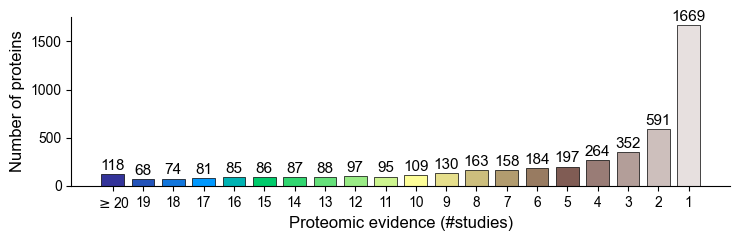

In [9]:
fig, ax_barchart = plt.subplots(1, 1, figsize=(7.5, 2.5))
sns.despine(ax=ax_barchart)

df_total_proteins = df_value_counts_colors["Total"]
rects = ax_barchart.bar(
    df_total_proteins.index,
    df_total_proteins.values,
    bar_size,
    color=df_value_counts_colors["Colors"].values,
    edgecolor=edgecolor,
    linewidth=edgewidth,
)
ax_barchart.bar_label(
    rects, labels=df_total_proteins.values, padding=1, fontsize=fontsize - 1
)
ax_barchart.set_xlabel(df_value_counts_colors.index.name, fontsize=fontsize)
ax_barchart.set_ylabel(f"Number of proteins", fontsize=fontsize)
all_figure_data["ProteomicEvidenceSummary"] = df_total_proteins.copy()
fig.tight_layout()
if save_figures:

    fig.savefig(
        f"{figures_path}/S1Fig_PanelB_AllProteomics.{imagetype}",
        transparent=transparent,
        format=imagetype,
        dpi=None if imagetype != "png" else dpi,
    )
fig;

## Aggregate Panels for visualization

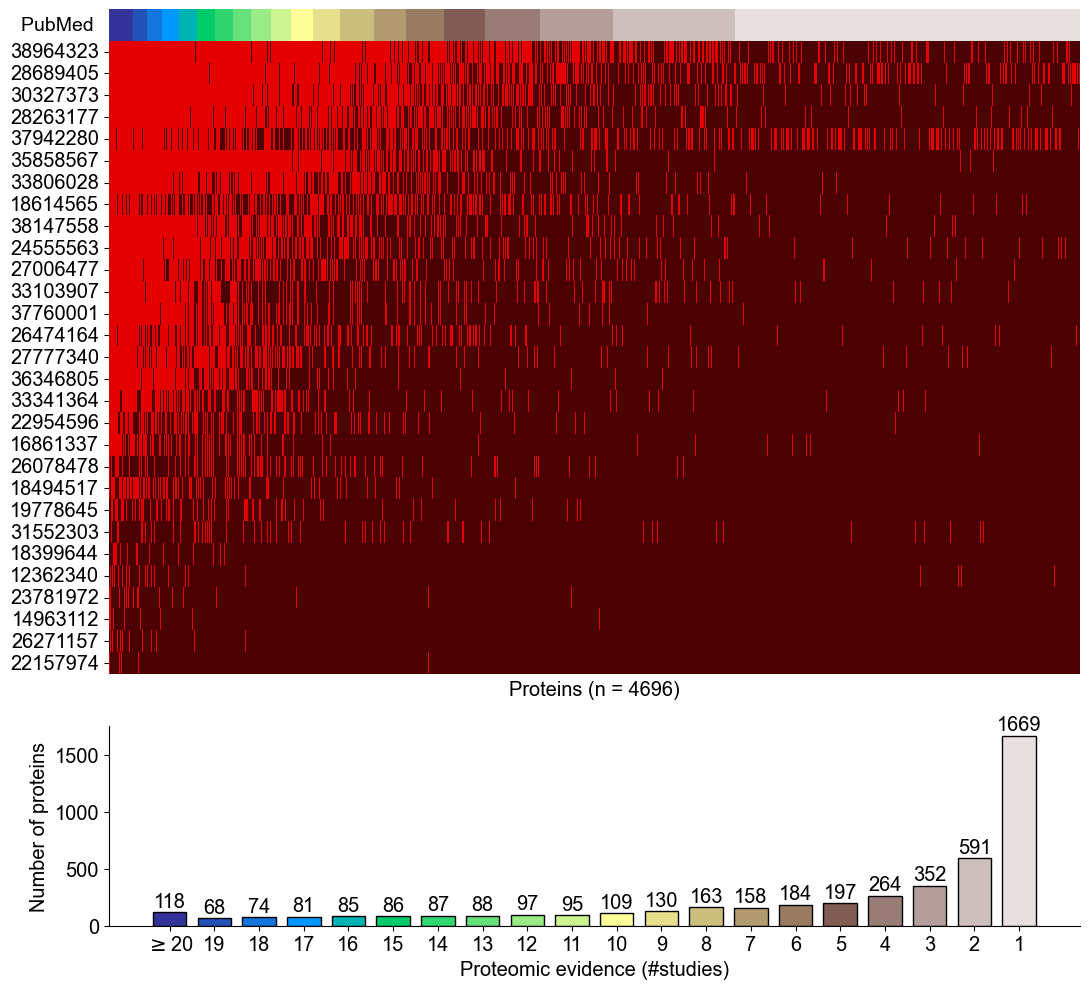

In [10]:
fig = mpl.figure.Figure(figsize=(11, 10))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[1, 0.3])
sgs = mpl.gridspec.GridSpecFromSubplotSpec(
    2, 1, hspace=0, height_ratios=[0.05, 1], subplot_spec=gs[0]
)

df_proteomic_cmap = df_figure_data.sum()
df_proteomic_cmap = df_proteomic_cmap.apply(lambda x: x if x < max_count else max_count)
df_proteomic_cmap = df_proteomic_cmap.apply(lambda x: x if x > min_count else min_count)

# Add col colors (similar to seaborn)
cmap_dict = df_value_counts_colors["Colors"].to_dict()
cmap_segmented = mpl.colors.LinearSegmentedColormap.from_list(
    "legend", [cmap_dict[c] for c in df_value_counts_colors.index[::-1]], len(cmap_dict)
)

ax_nstudies_colors = sns.heatmap(
    np.array([df_proteomic_cmap.values]),
    ax=fig.add_subplot(sgs[0]),
    xticklabels=False,
    yticklabels=False,
    cmap=cmap_segmented,
    cbar=False,
)


ax_heatmap = sns.heatmap(
    df_figure_data.rename(
        {row: row.lstrip("pubmed:") for row in df_figure_data.index}, axis=0
    ),
    ax=fig.add_subplot(sgs[1]),
    cbar=False,
    cmap=mpl.colors.ListedColormap(["xkcd:dried blood", "xkcd:red"]),
    xticklabels=False,
)
ax_heatmap.set_xlabel(
    f"Proteins (n = {len(df_figure_data.columns)})", fontsize=fontsize
)
ax_heatmap.set_xlabel(
    f"Proteins (n = {len(df_figure_data.columns)})", fontsize="x-large"
)
ax_heatmap.yaxis.tick_left()
ax_heatmap.tick_params(axis="y", labelsize="x-large")
ax_heatmap.set_ylabel(
    "PubMed ", ha="center", va="center", rotation=0, fontdict={"size": 14}
)
ax_heatmap.yaxis.set_label_coords(x=-0.05, y=1.025)

# Barchart
edgewidth = 1
ax_barchart = fig.add_subplot(gs[1])
sns.despine(ax=ax_barchart)
rects = ax_barchart.bar(
    df_total_proteins.index,
    df_total_proteins.values,
    bar_size,
    color=df_value_counts_colors["Colors"].values,
    edgecolor=edgecolor,
    linewidth=edgewidth,
)
ax_barchart.bar_label(
    rects, labels=df_total_proteins.values, padding=1, fontsize="x-large"
)

ax_barchart.xaxis.set_tick_params(labelsize="x-large")
ax_barchart.yaxis.set_tick_params(labelsize="x-large")
ax_barchart.set_xlabel(df_value_counts_colors.index.name, fontsize="x-large")
ax_barchart.set_ylabel(f"Number of proteins", fontsize="x-large")

all_figure_data["ProteomicEvidenceSummary"] = df_total_proteins.copy()
fig.tight_layout()
if save_figures:
    fig.savefig(
        f"{figures_path}/S1Fig_PanelAB_AllProteomics.{imagetype}",
        transparent=transparent,
        format=imagetype,
        dpi=None if imagetype != "png" else dpi,
    )
fig